In [1]:
%matplotlib notebook

import os
import shutil
import numpy as np
import covseisnet as cn
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tensorflow import keras
from models_yolo import UNet, CallBacks, DataGenerator
import h5py

from scipy.signal import tukey, butter, filtfilt
from scipy.stats import pearsonr

from time import time

from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio

from bm3d import bm3d
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import numpy.ma as ma

In [2]:
def insert_str(string, str_to_insert, index):
    return string[:index] + str_to_insert + string[index:]
def suppr_str(string, index, number_to_suppr):
    temp= index+number_to_suppr
    return string[:index] + string[temp:]
def suppr_gaps(stream):
    for i in range(len(stream)):
        average = stream[i].data.mean()
        stream[i].data=ma.filled(stream[i].data,average)
    return stream
def merge_traces_data_together(stream,number):
    for i in range(0,640*number,number):
        stream[int(i/number)]=stream[i]
        for j in range(1,number):
            stream[int(i/number)]+=stream[i+j]
    for i in range(640):
        for j in range(number-1):
                stream.pop(640)
    return stream

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=2):
    
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    
    if low < 0:
        Wn = high
        btype = "lowpass"
    elif high < 0:
        Wn = low
        btype = "highpass"
    else:
        Wn = [low, high]
        btype = "bandpass"

    b, a = butter(order, Wn, btype=btype)
    
    return b, a


def taper_filter(arr, fmin, fmax, samp_DAS):
    b_DAS, a_DAS = butter_bandpass(fmin, fmax, samp_DAS)
    window_time = tukey(arr.shape[1], 0.1)
    print(window_time)
    arr_wind = arr * window_time
    arr_wind_filt = filtfilt(b_DAS, a_DAS, arr_wind, axis=-1)
    return arr_wind_filt


def xcorr(x, y,i=0,j=0):
    
    # FFT of x and conjugation
    X_bar = np.fft.rfft(x).conj()
    Y = np.fft.rfft(y)
    
    # Compute norm of data
    norm_x_sq = np.sum(x**2)
    norm_y_sq = np.sum(y**2)
    norm = np.sqrt(norm_x_sq * norm_y_sq)
    if norm ==0:
        print("i",i)
    # Check if norm is zero before dividing
    
    # Correlation coefficients
    R = np.fft.irfft(X_bar * Y) / norm
    
    # Return correlation coefficient
    return np.max(R)

def compute_xcorr_window(x):
    Nch = x.shape[0]
    Cxy = np.zeros((Nch, Nch)) * np.nan
    
    for i in range(Nch):
        for j in range(i):
            Cxy[i, j] = xcorr(x[i], x[j],i,j)
    return np.nanmean(Cxy)

def compute_moving_coherence(data, bin_size):
    
    N_ch = data.shape[0]
    
    cc = np.zeros(N_ch)
    
    for i in range(N_ch):
        start = max(0, i - bin_size // 2)
        stop = min(i + bin_size // 2, N_ch)
        ch_slice = slice(start, stop)
        # slice of size bin_size ( smaller at the end and at the start of the dataset)
        cc[i] = compute_xcorr_window(data[ch_slice])
    return cc

In [4]:
with open('my_list.txt', 'r') as f:
    contents = f.read()

list_of_strings = contents.split('\n')
listing = [str(item) for item in list_of_strings if item]

In [9]:
with open('list_noisy_arrays.txt', 'r') as f:
    contents = f.read()

list_of_strings = contents.split('\n')
listing2 = [str(item) for item in list_of_strings if item]

In [6]:
pretrainfile = os.path.join("save", "model_11_m_data_stp_fonctionne.h5")
model = keras.models.load_model(pretrainfile)

In [14]:
# create an array of size (N_inputs,640,2048)
N_ch, N_t = (640,2048)
N_sub=11
data_reconstructions = np.zeros((N_ch,N_t))
cwd = os.getcwd()
data_dir = os.path.join(cwd, "reconstruction_noisy_model_denoised_inputs")
# Loop for each input. eval sample each have a shape (640,2048)
for n in range(len(listing[0:20])):
    """ Prepare samples and masks """
    # shape (640,11,2048,1)
    eval_sample = np.load(listing[n])
    masks = np.ones((N_ch, N_sub, N_t, 1))
    eval_samples = np.zeros_like(masks)
    # gutter and mid are both 5
    gutter = N_sub // 2
    mid = N_sub // 2
    for i in range(gutter):
        # 3 masks are put to 0
        masks[i, i:i+3] = 0
        # one channel of eval_samples contains the 11 first channels of eval_sample. shape :(11,2048)
        eval_samples[i, :, :, 0] = eval_sample[:N_sub]
        # i goes from 5 to 634
    for i in range(gutter, N_ch - gutter):
        #goes from 0 to 629
        start = i - mid
        # goes from 11 to 640
        stop = i + mid + 1
        masks[i, mid-1:mid+2] = 0
        #start:stop has a shape of 11 => consistent with first for loop
        eval_samples[i, :, :, 0] = eval_sample[start:stop]

    for i in range(N_ch - gutter, N_ch):
        masks[i, N_sub-3:N_sub] = 0
        eval_samples[i, :, :, 0] = eval_sample[-N_sub:]
    """ Create J-invariant reconstructions """
    results = model.predict((eval_samples, masks))
    for i in range(gutter):
        data_reconstructions[i] = results[i,i,:,0]
    for i in range(gutter, N_ch - gutter):
        data_reconstructions[i] = results[i,mid,:,0]
    for i in range(N_ch - gutter, N_ch):
        data_reconstructions[i] = results[i,N_sub-2,:,0]
    filename = f"reconstruction_{n}.h5"
    h5file = os.path.join(data_dir, filename)
    with h5py.File(h5file, "w") as h5f:
        h5f.create_dataset("strain_rate", data=data_reconstructions)

20/20 [==============================] - 4s 177ms/step


In [27]:
cwd = os.getcwd()
N_ch =640
n_t=2048
data_dir = os.path.join(cwd, "reconstruction_noisy_inputs")
data_recs = np.zeros((len(listing2[0:20]),N_ch,N_t))
for i in range(len(listing2[0:20])):
    data_rec_file = os.path.join(data_dir, f"reconstruction_{i}.h5")
    with h5py.File(data_rec_file, "r") as h5f:
        data_recs[i] = h5f["strain_rate"][...]

In [28]:
channel_number = 15
data = np.load(listing2[channel_number])
data_without_noise = np.load(listing[channel_number])

<IPython.core.display.Javascript object>


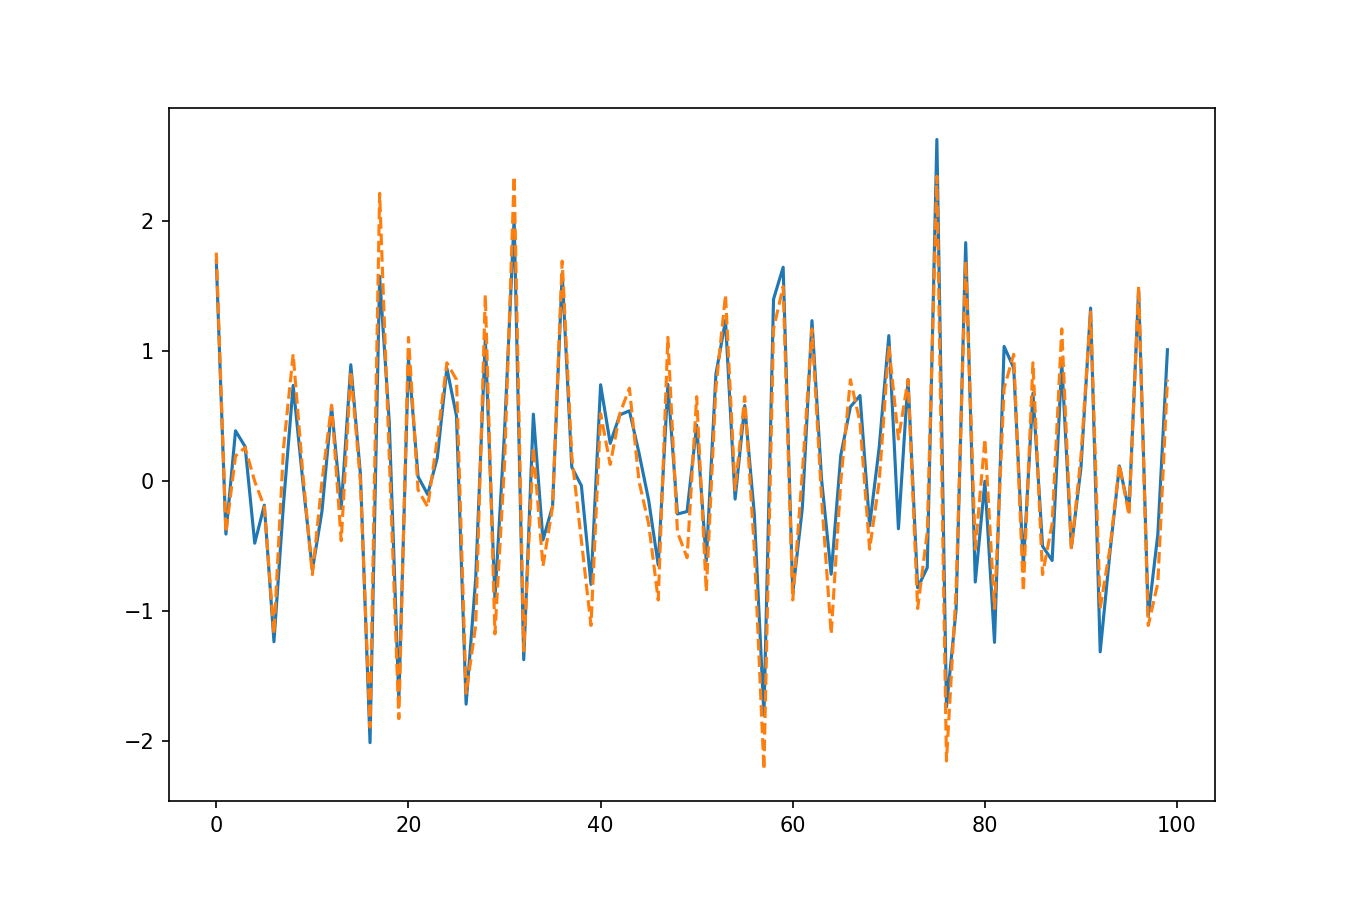

In [31]:
fig = plt.figure(figsize=(9, 6), dpi=150)
plt.plot(data[200][0:100])
plt.plot(data_without_noise[200][0:100],'--')
#plt.plot(data_recs[channel_number][30][0:300])

In [21]:
bin_size=10
cc_data = compute_moving_coherence(data, bin_size)
cc_rec = compute_moving_coherence(data_recs[channel_number], bin_size)

cc_gain = cc_rec / cc_data

i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3


<ipython-input-6-1a86148f7060>:46: RuntimeWarning: invalid value encountered in true_divide
  R = np.fft.irfft(X_bar * Y) / norm
<ipython-input-6-1a86148f7060>:58: RuntimeWarning: Mean of empty slice
  return np.nanmean(Cxy)


i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3


i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6


i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7


i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6


i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4


i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8


i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6


i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6


i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8


i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8


i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8


i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9


i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 8
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 9
i 1
i 2
i 2
i 3
i 3
i 3
i 4
i 4
i 4
i 4
i 5
i 5
i 5
i 5
i 5
i 6
i 6
i 6
i 6
i 6
i 6
i 7
i 7
i 7


<IPython.core.display.Javascript object>


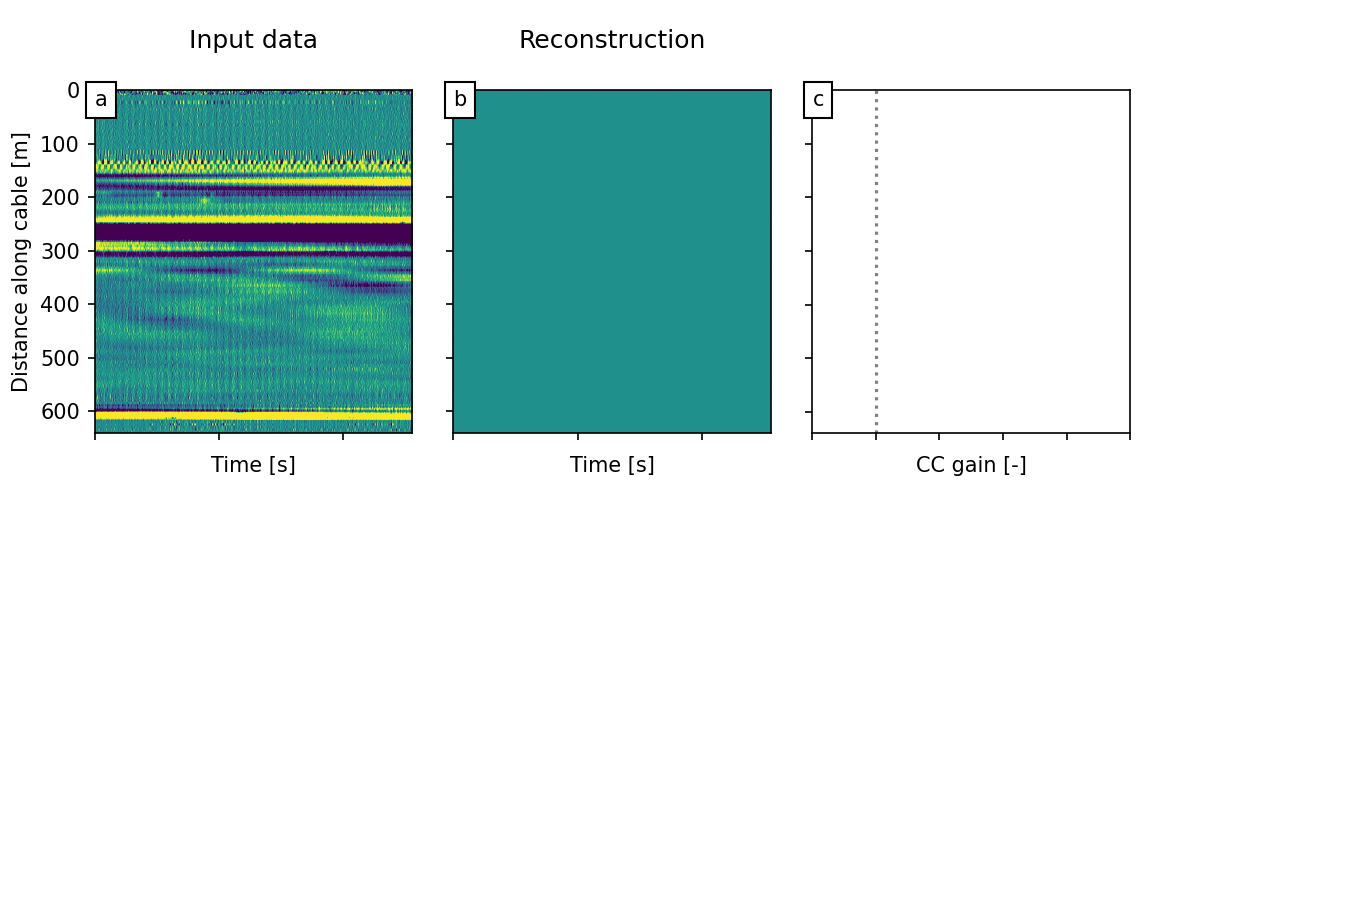

In [22]:
gauge = 1
samp=4000
dist = np.arange(N_ch) * gauge

imshow_params = {
    "vmin": -0.5,
    "vmax": 0.5,
    "aspect": "auto",
    "interpolation": "antialiased",
    "cmap": "viridis",
    "extent": [0, N_t/samp, N_ch*gauge, 0],
    "rasterized": True,
}

letters = "abcdefghijk"
letter_params = {
    "fontsize": 10,
    "verticalalignment": "top",
    "bbox": {"edgecolor": "k", "linewidth": 1, "facecolor": "w",}
}


# Draw canvas
fig = plt.figure(figsize=(9, 6), dpi=150)
gs = fig.add_gridspec(2, 7)

axes = []

""" Panel a """
ax = fig.add_subplot(gs[0, 0:2])
axes.append(ax)
ax.imshow(data, **imshow_params)
ax.set_ylabel("Distance along cable [m]")
ax.set_title("Input data", pad=20)
ax.xaxis.set_ticklabels([])
ax.set_ylabel("Distance along cable [m]")
ax.set_xlabel("Time [s]")

""" Panel b """
ax = fig.add_subplot(gs[0, 2:4])
axes.append(ax)
ax.imshow(data_recs[channel_number], **imshow_params)
ax.set_title("Reconstruction", pad=20)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.set_xlabel("Time [s]")


""" Panel d """
ax = fig.add_subplot(gs[0, 4:6])
axes.append(ax)
ax.plot(cc_gain, dist, c="k")
ax.axvline(1, ls=":", c="gray")
ax.set_xlim((0, 5))
ax.set_ylim((dist.max(), dist.min()))
ax.yaxis.set_ticklabels([])
ax.xaxis.set_ticklabels([])
ax.set_xlabel("CC gain [-]")
# Add panel letters
for i, ax in enumerate(axes):
    if i < 3: 
        ax.text(x=0.0, y=1.0, transform=ax.transAxes, s=letters[i], **letter_params)
# Adjust panel positions
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.07, right=0.97, hspace=0.1, wspace=0.3)

plt.savefig("figures/dropout.pdf")
plt.show()

<IPython.core.display.Javascript object>


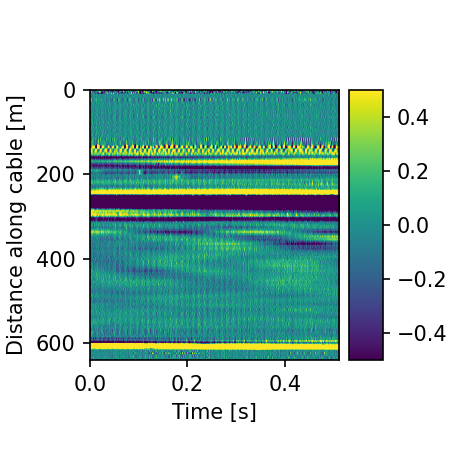

In [24]:
gauge = 1
samp=4000
Nch=640
Nt=2048
dist = np.arange(Nch) * gauge

imshow_params = {
    "vmin": -0.5,
    "vmax": 0.5,
    "aspect": "auto",
    "interpolation": "antialiased",
    "cmap": "viridis",
    "extent": [0, Nt/samp, Nch*gauge, 0],
    "rasterized": True,
}

letters = "abcdefghijk"
letter_params = {
    "fontsize": 10,
    "verticalalignment": "top",
    "bbox": {"edgecolor": "k", "linewidth": 1, "facecolor": "w",}
}


# Draw canvas
fig = plt.figure(figsize=(3, 3), dpi=150)
gs = fig.add_gridspec(1, 7)

axes = []

""" Panel a """
ax = fig.add_subplot(gs[0, 0:6])
axes.append(ax)
im = ax.imshow(data, **imshow_params)
ax.set_ylabel("Distance along cable [m]")
ax.set_xlabel("Time [s]")

# Color bar
cax = fig.add_subplot(gs[0, 6])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Amplitude [-]", labelpad=10)
# Adjust panel positions
plt.subplots_adjust(top=0.8, bottom=0.2, left=0.2, right=0.85, hspace=0.1, wspace=0.3)

plt.savefig("figures/original_image.pdf")
plt.show()